In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn_extra.cluster import KMedoids
from sklearn.feature_extraction.text import CountVectorizer
from data_parsing import DataParser
import seaborn as sb
import os

#### Comment out either AM or LaaL depending on what you want to run.  Make sure to use correct csv data files for subsequent analysis

In [2]:
sb.set(context='notebook', style='white', palette='deep', font='Times', font_scale=1, color_codes=True, rc=None)

## AM dataset
dataAM = DataParser('course_data/MITxPRO+AMxB+1T2018/edges', 'course_data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
id_and_performance = pd.read_csv('course_data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')

## LaaL dataset
# dataLaaL = DataParser('course_data/MITxPRO+LASERxB1+1T2019/edges', 'course_data/MITxPRO+LASERxB1+1T2019/MITxPRO-LASERxB1-1T2019-auth_user-students.csv')
# id_and_performance = pd.read_csv('course_data/MITxPRO+LASERxB1+1T2019/MITxPRO-LASERxB1-1T2019-auth_user-students.csv')

In [3]:
trajectories = dataAM.trajectories
status = dataAM.status

In [4]:
vectorizer = CountVectorizer(ngram_range=[2,2])
url_counts = vectorizer.fit_transform(list(trajectories.apply(lambda x : " ".join([str(url) for url in x]))))
len(vectorizer.get_feature_names())

31648

In [25]:
def get_medoid_clusters(k):
    kmedoids = KMedoids(n_clusters = k).fit(url_counts)
    kmedoids.labels_
    
    labels = pd.DataFrame(kmedoids.labels_)
    labels['index'] = trajectories.index
    labels['is exemplar'] = 0
    for exemplar in kmedoids.medoid_indices_:
        labels.iloc[exemplar, 2] = 1
    # labels.to_csv('MITxPRO+LASERxB1+1T2019_kmedoids {} clusters.csv'.format(k), header = ['cluster id', 'user id', 
    # 'is exemplar'], index = False)  
    clusters = []
    cluster_id = []
    cluster_len = []
    for i in range(k):
        clusters.append([])
        cluster_id.append([])
        cluster_len.append([])
        
    for i, label in enumerate(kmedoids.labels_):
        clusters[label].append(trajectories.index[i])
        cluster_id[label].append(i)
        cluster_len[label].append(len(trajectories.iloc[i]))
    print([np.mean(x) for x in cluster_len])
    fig = plt.figure(figsize=(7,3.5))
    for i in range(k):
        sb.distplot(cluster_len[i], bins=[0,250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500],
                   kde=False)
        plt.title('AM 4-cluster distribution')
        plt.xlabel('Number of clicks in trajectory')
        plt.ylabel('Trajectories')
    fig.legend(labels=range(k))
    plt.show()
    return cluster_id

[829.7137096774194, 389.994623655914]


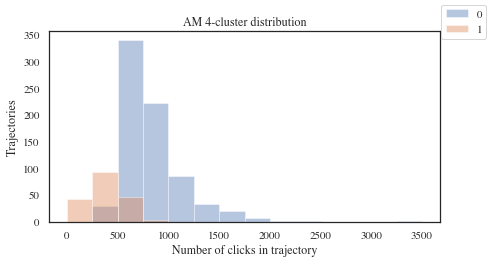

[0.03850127 0.01443559]
[813.8352059925094, 373.4080459770115, 857.1396396396397]


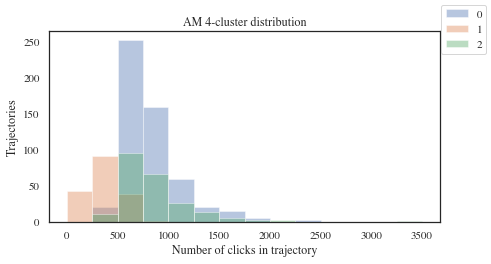

[0.03639269 0.01370657 0.04284131]
[736.012853470437, 371.1046511627907, 761.6213017751479, 1054.965]


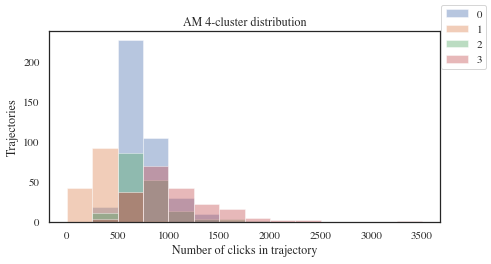

[0.02967598 0.01359317 0.032548   0.05966508]
[744.0524781341107, 368.72352941176473, 771.979020979021, 1090.287356321839, 718.5]


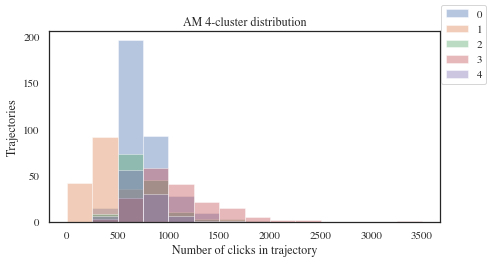

[0.03010972 0.01350962 0.03318537 0.06303905 0.0297538 ]
[764.0526315789474, 788.9391304347826, 596.9109947643979, 755.8732394366198, 1143.9797297297298, 295.64356435643566]


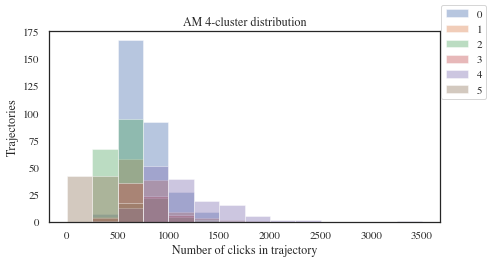

[0.03118641 0.03379869 0.02421345 0.03184922 0.06737015 0.0107535 ]


In [26]:
variance_by_k = []
ks = list(range(2,7))
for k in ks:
    cluster_id = get_medoid_clusters(k)
    
    cluster_variances = []
    for i in range(k):
        cluster_variances.append(url_counts.todense()[cluster_id[i]].var())
    cluster_variances = np.array(cluster_variances)
    cluster_counts = np.array([len(x) for x in cluster_id])
    variance_by_k.append((cluster_variances*cluster_counts/len(trajectories)).sum())
    print(cluster_variances)

Text(0.5, 1.0, 'K-medoid clustering for AM course')

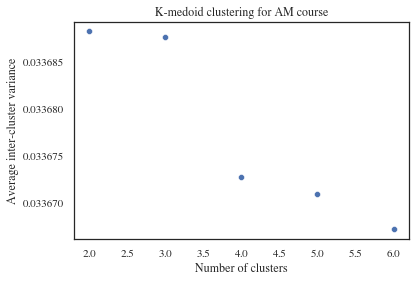

In [8]:
sb.scatterplot(ks, variance_by_k, x_bins=[0,2,3,4,5,6])
plt.xlabel('Number of clusters')
plt.ylabel('Average inter-cluster variance')
plt.title('K-medoid clustering for AM course')

In [20]:
# status = id_and_performance[id_and_performance['certGrp']== 'Certified (< 65% Grade)']
# cluster_df = pd.read_csv('edx-learnerpathway-modeling/k_medoid_sample_clusters/kmedoids_4_clusters.csv')
# performance_df = pd.merge(cluster_df, id_and_performance, left_on='user id', right_on='id')
# performance_df['cluster id'] = pd.Categorical(performance_df['cluster id'])
# performance_table = performance_df.groupby(['cluster id','certGrp'], as_index=False, observed=False).count()[['cluster id', 'certGrp', 'id']]
# performance_table.columns = ['cluster id', 'certificate status', 'count']
# performance_table

In [12]:
# LaaL_edelist = pd.read_csv('course_data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-edges.csv')
# LaaL_edelist[:5]